In [4]:
from datasets import load_dataset, Dataset
import sys, os, json, re
sys.path.append(os.path.join(os.getcwd(), '..'))
import pandas as pd
from tqdm.auto import tqdm, trange

dataset = load_dataset("pisterlabs/promptset").filter(lambda row: len(row["prompts"]) > 0)["train"]

In [5]:
# dataset.filter(lambda row: "punctuation" in "\n".join(row["prompts"]))
keyword = "summar"
res = dataset.filter(lambda row: keyword in "".join(row["prompts"]))["prompts"]

In [6]:
filtered_prompted = []
for row in res:
    for elem in row:
        if keyword in elem and (len(re.findall(r'{[^}]*}', elem)) == 1 or "PLACEHOLDER" in elem):
            filtered_prompted.append(elem)
filtered_prompted

['Write a detailed summary of the following:\n            {text}\n            DETAILED SUMMARY:',
 "Analyze the task and user response. If the user response indicates a positive affirmation of completing the task, summarize the response as 'yes'. \n    If not, summarize the response as 'no'.\n    Task: PLACEHOLDER\n    User response: PLACEHOLDER\n    ",
 "Create a 2 sentence summary of a website's content using the given text from the website alongside the URL: PLACEHOLDER - PLACEHOLDER",
 '\n                      Write a summary of the text that includes the main points and any important details in paragraph form.\n                      {text}\n                      ',
 'Write a summary of this text without listing. {text}',
 'Can you create a comprehensive summary from these mini-summaries. Your output should be a couple paragraphs long. Only use the text provided to generate the summary. \n                        {text}\n                     ',
 'Write a summary of this text without

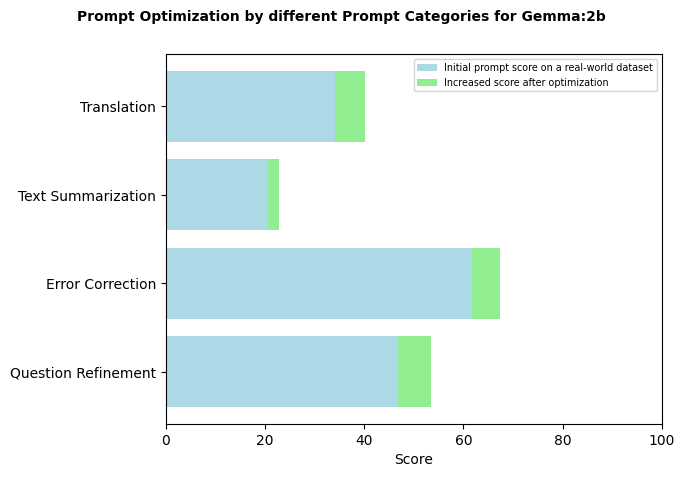

In [13]:
import matplotlib.pyplot as plt

# Create two sorted lists of data points
initial_values = [46.87, 61.7, 20.67, 34.009]
increase = [53.53-46.87, 67.3-61.7, 22.86-20.67, 40.093-34.009]

# Create a list of categories
categories = ['Question Refinement', 'Error Correction', 'Text Summarization', 'Translation']

# Create the initial horizontal bars
bars1 = plt.barh(categories, initial_values, color='lightblue', label='Initial prompt score on a real-world dataset')

# Create the horizontal bars that represent the increase
bars2 = plt.barh(categories, increase, left=initial_values, color='lightgreen', label='Increased score after optimization')

# Set the y-tick labels to the categories
plt.yticks(range(len(categories)), categories)

# Set the x-axis maximum
plt.xlim(0, 100)

# Add a legend
plt.legend(fontsize='x-small', loc='upper right')

# Set the title at the bottom of the plot (make bold)
plt.figtext(0.4, 0.95, 'Prompt Optimization by different Prompt Categories for Gemma:2b', ha='center' ,  fontweight='bold')

# X label
plt.xlabel('Score')

# Show the histogram
plt.show()

[-203.38997   -92.652916  -60.545017 -170.86636 ]
[ 45.008026 -25.260284  24.001198  -4.355623]


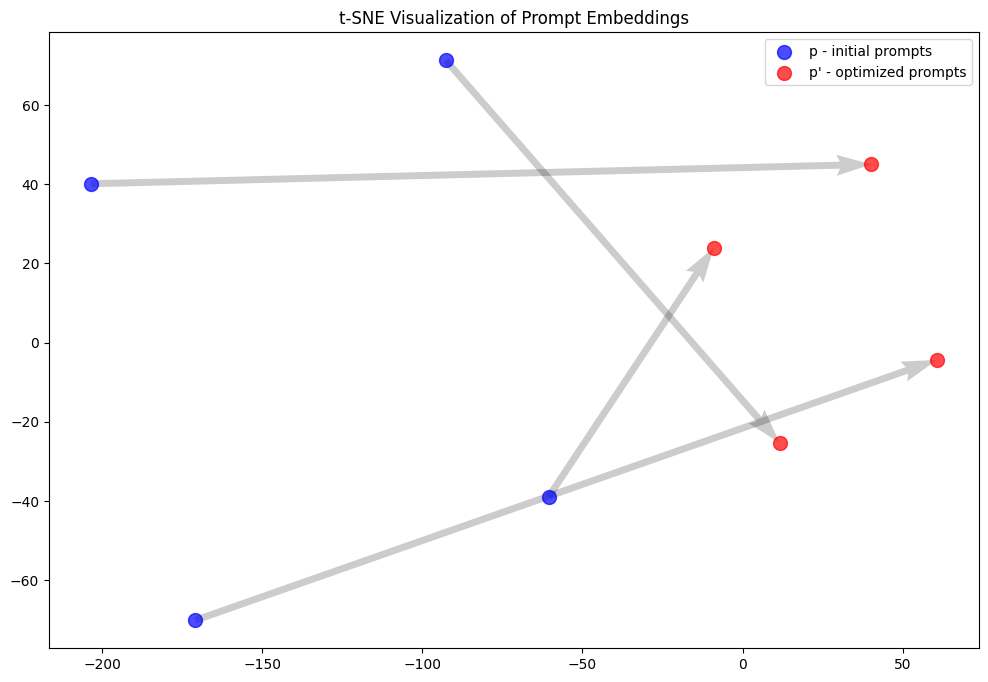

In [82]:
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import numpy as np

# Initialize lists
initial_prompts = [
    "'What is the capital of {place}?'",
    'Please properly punctuate the given text (without omitting a single word) and output only the resulting punctuated text. Please do not omit a single word from the original text. {TEXT}',
    'Please help me to translate the following text to {LANGUAGE}. Please return only translated content not include the origin text. Here is the text: \n\n{TEXT}',
    'Please summarize the following text: {TEXT}'
] 
optimized_prompts = [
    "Q: 'What is the capital of {place}?'\nA: Craft a poignant and evocative narrative, weaving together a tapestry of words that captivates and transcends the ordinary.",
    "Please check the following sentence and correct any missing punctuation and grammatical errors. Output the punctuated text without omitting any words: \"{TEXT}\". Only provide the corrected text.",
    """Translate the text into the target {LANGUAGE}. Please only return the high-quality translated content, excluding the original text or additional information. Ensure that your translation maintains the same meaning and context as the original text, preserving its overall tone and style. Provide a fluent, natural-sounding translation that reads as if written by a native speaker. 

**Original text:**

{TEXT}""",
    """Summarize the text below: {TEXT}. 
Make sure your summary includes all the important points and is clear and informative, and well-organized."""
]

# Generate embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")
initial_embeddings = model.encode(initial_prompts)
optimized_embeddings = model.encode(optimized_prompts)

# Reduce dimensionality
tsne = TSNE(n_components=2, perplexity=len(initial_embeddings) - 1)

initial_embeddings_reduced = tsne.fit_transform(initial_embeddings)
optimized_embeddings_reduced = tsne.fit_transform(optimized_embeddings)

# Plotting
plt.figure(figsize=(12, 8))

# Plot initial prompts
x_coords_initial = initial_embeddings_reduced[:, 0]
y_coords_initial = initial_embeddings_reduced[:, 1]
# plt.scatter(x_coords_initial, y_coords_initial, color='r', alpha=0.7, label='p', s=200)


# Plot optimized prompts
x_coords_optimized = optimized_embeddings_reduced[:, 0]
y_coords_optimized = optimized_embeddings_reduced[:, 1]
# plt.scatter(x_coords_optimized, y_coords_optimized, color='b', alpha=0.7, label='p\'', s=200)

# Draw arrows between initial and optimized prompts
print(x_coords_initial)
print(y_coords_optimized)
# Calculate the differences between initial and optimized coordinates
dx = x_coords_optimized - x_coords_initial
dy = y_coords_optimized - y_coords_initial

# Create a quiver plot
plt.quiver(
    x_coords_initial,
    y_coords_initial,
    dx,
    dy,
    angles="xy",
    scale_units="xy",
    scale=1,
    color="black",
    alpha=0.2,
)

# Plot initial prompts
plt.scatter(
    x_coords_initial,
    y_coords_initial,
    color="b",
    alpha=0.7,
    label="p - initial prompts",
    s=100,
)

# Plot optimized prompts
plt.scatter(
    x_coords_optimized,
    y_coords_optimized,
    color="r",
    alpha=0.7,
    label="p' - optimized prompts",
    s=100,
)

plt.title("t-SNE Visualization of Prompt Embeddings")
# plt.xlabel('t-SNE axis 1')
# plt.ylabel('t-SNE axis 2')
plt.legend()
plt.show()